## Carga de módulos

In [1]:
import os
import time
import boto3
import joblib
import warnings
import pandas as pd
from config import region_name
from utilities.sagemaker_functions import create_model, transform, \
                                          download_model, decompress_model, prediction_df
from utilities.evaluation import generate_report, confusion_matrix, \
                                 calculate_metrics, metrics_summary


import sagemaker
from smdebug.trials import create_trial
from sagemaker.pipeline import PipelineModel
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role, s3_input
from sagemaker.content_types import CONTENT_TYPE_CSV
from sagemaker.predictor import RealTimePredictor, csv_serializer, csv_deserializer, \
                                json_serializer, json_deserializer


warnings.filterwarnings('ignore')

In [2]:
role = get_execution_role()
session = sagemaker.Session()

Primero vamos a instanciar diferentes variables, por ejemplo, el bucket donde se encuentran los datos alojados para el entrenamiento del XGBoost.

In [3]:
bucket = 'banking-data'
prefix = 'churn-modeling'

train_path = f's3://{bucket}/{prefix}/train/train.csv'
test_path = f's3://{bucket}/{prefix}/test/test.csv'
validation_path = f's3://{bucket}/{prefix}/validation/validation.csv'

output_path = f's3://{bucket}/{prefix}/output'

### Preprocesamiento (primer contenedor)

In [4]:
preprocessor = SKLearn(entry_point='scikit_preprocessing.py',
                       role=role,
                       train_instance_type='ml.m4.xlarge',
                       sagemaker_session=session,
                       dependencies=['config.py', 'custom_pipeline.py'],
                       py_version='py3')

preprocessor.fit({'train': s3_input(train_path, content_type='text/csv')}, job_name='scikit-preprocessing-2')

2020-05-11 19:26:43 Starting - Preparing the instances for training
2020-05-11 19:26:43 Downloading - Downloading input data
2020-05-11 19:26:43 Training - Training image download completed. Training in progress.
2020-05-11 19:26:43 Uploading - Uploading generated training model
2020-05-11 19:26:43 Completed - Training job completed2020-05-11 19:26:31,468 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-05-11 19:26:31,470 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-11 19:26:31,482 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-05-11 19:26:31,911 sagemaker-containers INFO     Module scikit_preprocessing does not provide a setup.py. 
Generating setup.py
2020-05-11 19:26:31,911 sagemaker-containers INFO     Generating setup.cfg
2020-05-11 19:26:31,911 sagemaker-containers INFO     Generating MANIFEST.in
2020-05-11 19:26:31,911 sagemaker-containers INFO     Installing modul

## Tranformación por lotes de los datos

In [5]:
transform(preprocessor, data=train_path, output_path=output_path, instance_type='ml.m4.xlarge')

......................Processing /opt/ml/code
  Created wheel for scikit-preprocessing: filename=scikit_preprocessing-1.0.0-py2.py3-none-any.whl size=11182 sha256=07da30184e4e0186eccc700ad7c82977412afd25f6a471dd427a000bd1060cbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1mu4ddg/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built scikit-preprocessing
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2020-05-11 19:30:44 +0000] [37] [INFO] Starting gunicorn 19.9.0
[2020-05-11 19:30:44 +0000] [37] [INFO] Listening at: unix:/tmp/gunicorn.sock (37)
[2020-05-11 19:30:44 +0000] [37] [INFO] Using worker: gevent
[2020-05-11 19:30:44 +0000] [40] [INFO] Booting worker with pid: 40
[2020-05-11 19:30:44 +0000] [41] [INFO] Booting worker with pid: 41
[2020-05-11 19:30

In [6]:
transform(preprocessor, data=validation_path, output_path=output_path, instance_type='ml.m4.xlarge')

Using already existing model: scikit-preprocessing-2


.......................Processing /opt/ml/code
  Created wheel for scikit-preprocessing: filename=scikit_preprocessing-1.0.0-py2.py3-none-any.whl size=11182 sha256=a759324e3893cfcf90ca16dc5d63c43bfb3444f3ff1574549263624db32fa03a
  Stored in directory: /tmp/pip-ephem-wheel-cache-afybk29v/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built scikit-preprocessing
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2020-05-11 19:35:22 +0000] [40] [INFO] Starting gunicorn 19.9.0
[2020-05-11 19:35:22 +0000] [40] [INFO] Listening at: unix:/tmp/gunicorn.sock (40)
[2020-05-11 19:35:22 +0000] [40] [INFO] Using worker: gevent
[2020-05-11 19:35:22 +0000] [43] [INFO] Booting worker with pid: 43
[2020-05-11 19:35:22 +0000] [44] [INFO] Booting worker with pid: 44
[2020-05-11 19:3

In [7]:
transform(preprocessor, data=test_path, output_path=output_path, instance_type='ml.m4.xlarge')

Using already existing model: scikit-preprocessing-2


.....................Processing /opt/ml/code
  Created wheel for scikit-preprocessing: filename=scikit_preprocessing-1.0.0-py2.py3-none-any.whl size=11181 sha256=18ec9bc94f815baef1135e6238fbe08fb0b143fa045f76e0e9a289e0470e7d36
  Stored in directory: /tmp/pip-ephem-wheel-cache-2b2n69f6/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built scikit-preprocessing
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2020-05-11 19:39:05 +0000] [38] [INFO] Starting gunicorn 19.9.0
[2020-05-11 19:39:05 +0000] [38] [INFO] Listening at: unix:/tmp/gunicorn.sock (38)
[2020-05-11 19:39:05 +0000] [38] [INFO] Using worker: gevent
[2020-05-11 19:39:05 +0000] [41] [INFO] Booting worker with pid: 41
[2020-05-11 19:39:05 +0000] [45] [INFO] Booting worker with pid: 45
[2020-05-11 19:39:

## XGBoost (Segundo contenedor)

In [5]:
hyperparams = {
    'objective': 'binary:logistic',
    'early_stopping_rounds': 10,
    'num_round': 250,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 4
}

job_name = 'xgboosting-baseline'
xgb = create_model(image='xgboost', role=role, hyperparameters=hyperparams,
                   instance_type='ml.m4.xlarge', output_path=output_path,
                   region_name=region_name, s3_train=f'{output_path}/train.csv.out',
                   s3_validation=f'{output_path}/validation.csv.out', job_name=job_name)

2020-05-11 19:50:53 Starting - Preparing the instances for training
2020-05-11 19:50:53 Downloading - Downloading input data
2020-05-11 19:50:53 Training - Training image download completed. Training in progress.
2020-05-11 19:50:53 Uploading - Uploading generated training model
2020-05-11 19:50:53 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:47:16] 7000x11 matrix with 77000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimi

## Evaluación del modelo base (Benchmark)

In [6]:
test_label = pd.read_csv(f's3://{bucket}/{prefix}/test/test_label.csv', sep=';', names=['label'])
benchmark = pd.DataFrame([0] * test_label.shape[0], columns=['prediction'])

metrics = calculate_metrics(test_label['label'], benchmark['prediction'])

In [7]:
metrics_summary(metrics)
confusion_matrix(test_label['label'], benchmark['prediction'])

The AUC is: 0.5
The accuracy is: 0.8
The precision is: 0.0
The recall is: 0.0
The F1 score is: 0.0


Predicted,0
Observed,
0,1.0
1,1.0


## Evaluación del modelo

In [9]:
download_model(model_path=f'{output_path}/{job_name}/output/model.tar.gz',
               local_dir=f'models/{job_name}/model.tar.gz')
decompress_model(local_dir=f'models/{job_name}/model.tar.gz')

0

In [10]:
model = joblib.load('xgboost-model')
prediction = prediction_df(model, file_path=f'{output_path}/test.csv.out', score=0.5)
metrics = calculate_metrics(test_label['label'], prediction['prediction'])

In [11]:
generate_report(test_label['label'], prediction['prediction'])

,f1-score,precision,recall,support
0,0.86,0.93,0.81,956.0
1,0.60,0.50,0.75,244.0
micro avg,0.80,0.80,0.80,1200.0
macro avg,0.73,0.71,0.78,1200.0
weighted avg,0.81,0.84,0.80,1200.0


In [12]:
metrics_summary(metrics)
confusion_matrix(test_label['label'], prediction['prediction'])

The AUC is: 0.78
The accuracy is: 0.8
The precision is: 0.5
The recall is: 0.75
The F1 score is: 0.6


Predicted,0,1
Observed,,
0,0.81,0.19
1,0.25,0.75


## Optimización de hiperparametros

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri

hyperparams = {
    'objective': 'binary:logistic',
    'early_stopping_rounds': 10,
    'num_round': 200,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 4
}

container = get_image_uri(region_name, 'xgboost', '0.90-2')

model = sagemaker.estimator.Estimator(container,
                                      role=role,
                                      train_instance_count=1,
                                      train_instance_type='ml.m4.xlarge',
                                      train_use_spot_instances=True,
                                      train_max_run=300,
                                      train_max_wait=600,
                                      output_path=output_path,
                                      sagemaker_session=session)

model.set_hyperparameters(**hyperparams)

In [18]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator=model,
                                               objective_metric_name='validation:f1',
                                               objective_type='Maximize',
                                               max_jobs=20,
                                               max_parallel_jobs=3,
                                               hyperparameter_ranges={
                                                   'max_depth': IntegerParameter(3, 12),
                                                   'num_round': IntegerParameter(100, 300),
                                                   'subsample': ContinuousParameter(0.5, 0.9)
                                               })

In [19]:
s3_input_train = sagemaker.s3_input(s3_data=f'{output_path}/train.csv.out', content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=f'{output_path}/validation.csv.out', content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, job_name='xgboost-tuner')

In [20]:
xgb_hyperparameter_tuner.wait()

..........................................................................................................................................................................................................................................................................................!


In [21]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-tuner-012-36066e2c'

In [22]:
tuner = xgb_hyperparameter_tuner.best_training_job()
download_model(model_path=f'{output_path}/{tuner}/output/model.tar.gz',
               local_dir=f'models/{tuner}/model.tar.gz')
decompress_model(local_dir=f'models/{tuner}/model.tar.gz')

0

In [23]:
model = joblib.load('xgboost-model')
prediction = prediction_df(model, file_path=f'{output_path}/test.csv.out', score=0.5)
metrics = calculate_metrics(test_label['label'], prediction['prediction'])

In [24]:
generate_report(test_label['label'], prediction['prediction'])

,f1-score,precision,recall,support
0,0.89,0.89,0.89,956.0
1,0.57,0.57,0.57,244.0
micro avg,0.83,0.83,0.83,1200.0
macro avg,0.73,0.73,0.73,1200.0
weighted avg,0.83,0.83,0.83,1200.0


In [25]:
metrics_summary(metrics)
confusion_matrix(test_label['label'], prediction['prediction'])

The AUC is: 0.73
The accuracy is: 0.83
The precision is: 0.57
The recall is: 0.57
The F1 score is: 0.57


Predicted,0,1
Observed,,
0,0.89,0.11
1,0.43,0.57


## Interpretabilidad del modelo

In [31]:
decompress_model(local_dir=f'models/{job_name}/model.tar.gz')

0

In [32]:
model = joblib.load('xgboost-model')

In [54]:
features = {
    'f0': 'CreditScore',
    'f1': 'Age',
    'f2': 'Tenure',
    'f3': 'Balance',
    'f4': 'NumOfProducts',
    'f5': 'EstimatedSalary',
    'f6': 'Geography_Spain',
    'f7': 'Geography_Germany',
    'f8': 'Gender_Male',
    'f9': 'HasCrCard_False',
    'f10': 'IsActiveMember_False'
}

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(df: pd.DataFrame, col: str):
    """
    Take a dataframe and graph the barchart of the variable of interest
    :param df:
    :param col:
    :return:
    """
    aux = df[col].sort_values(ascending=True)
    bars = tuple(aux.index.tolist())
    values = aux.values.tolist()
    y_pos = np.arange(len(bars))
    colors = ['lightblue'] * len(bars)
    colors[-1] = 'blue'
    plt.figure(figsize=(10, 8))
    plt.barh(y_pos, values, color=colors)
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.yticks(y_pos, bars)
    return plt.show()

In [56]:
importance = model.get_score(importance_type='gain')
importance = pd.DataFrame.from_dict({f'{key}': [value] for key, value in importance.items()}).T
importance.columns = ['fscore']
importance.rename(index=features, inplace=True)
importance

,fscore
Age,105.556351
Geography_Germany,44.138304
Gender_Male,36.578548
IsActiveMember_False,51.491901
CreditScore,10.870150
NumOfProducts,132.805597
Balance,31.692065
EstimatedSalary,8.456278
Tenure,8.352501
Geography_Spain,19.125022


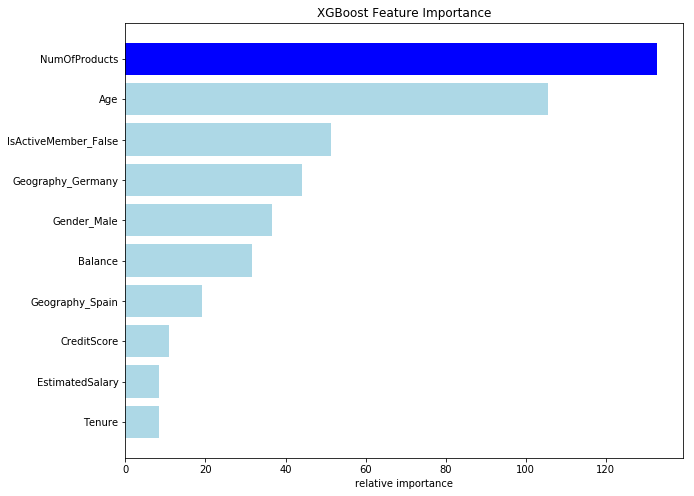

In [71]:
plot_feature_importance(df=importance, col='fscore')

## Pipeline de inferencia

In [26]:
scikit_preprocessor = preprocessor.create_model(env={"SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT": "text/csv"})
xgboost = xgb.create_model()

model_name = 'churn-score-pdn'
endpoint_name = 'churn-score-pdn'

model = PipelineModel(name=model_name,
                      role=role,
                      models=[
                          scikit_preprocessor,
                          xgboost
                      ])

In [27]:
model.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name)

---------------------!

In [28]:
def calculate_churn_score(data: str):
    client = boto3.client('sagemaker-runtime', 'us-east-1')
    score_endpoint = 'churn-score-pdn'
    response = client.invoke_endpoint(EndpointName=score_endpoint,
                                      Body=data,
                                      ContentType='text/csv',
                                      Accept='text/csv')
    score = 1 if float(response['Body'].read().decode('utf-8')) >= 0.5 else 0
    return score

In [29]:
new_data = '4635;15583353;Floyd;610;Spain;Female;45;3;0.0;1;1;0;38276.84'

In [30]:
start = time.time()

print(f'The prediction for new_user is: {calculate_churn_score(new_data)}')

end = time.time() - start

print(f'The prediction in seconds is: {end}')

The prediction for new_user is: 1
The prediction in seconds is: 0.2564730644226074
